Decision trees
---

In [1]:
import pandas as pd
import os

# Load data
data_df = pd.read_csv('titanic.csv')

# First five rows
data_df.head()

,name,pclass,age,sex,survived
0,"Hirvonen, Miss Hildur E",3rd,2,female,0
1,"Van Impe, Miss Catharine",3rd,10,female,0
2,"Sjostedt, Mr Ernst Adolf",2nd,59,male,0
3,"Fortune, Mr Mark",1st,64,male,0
4,"Ware, Mr William J",2nd,23,male,0


In [2]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=['pclass'])

# Encode binary variables with 0s and 1s
encoded_df['sex'] = encoded_df.sex.replace({
    'male': 0,
    'female': 1
})

# First five rows
encoded_df.head()

,name,age,sex,survived,pclass_1st,pclass_2nd,pclass_3rd
0,"Hirvonen, Miss Hildur E",2,1,0,0,0,1
1,"Van Impe, Miss Catharine",10,1,0,0,0,1
2,"Sjostedt, Mr Ernst Adolf",59,0,0,0,1,0
3,"Fortune, Mr Mark",64,0,0,1,0,0
4,"Ware, Mr William J",23,0,0,0,1,0


In [3]:
import numpy as np

# Select features
features = encoded_df.drop(['name', 'survived'], axis=1)

# Create X/y variables
X = features
y = encoded_df.survived

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=1, random_state=0)

In [5]:
# Fit decision tree
dt.fit(X, y)

# Get score
dt.score(X, y)

0.7791005291005291

We get an accuracy around 78% which is already much better than the "most-frequent" baseline.
### Baseline

In [6]:
# Proportion of features in each class
pd.value_counts(y, normalize=True)

0    0.585979
1    0.414021
Name: survived, dtype: float64

Note that we removed part of the entries labeled with "died" in the titanic.csv file to have a more balanced the data set (the survival rate is around 30% according to Wikipedia and not 40% as above). Decision trees try to minimize the impurity at each split. Hence, if there are more samples from one class than the others, it will focus on building rules that correctly classify data points from this class. In our case, we want to build a decision tree that can classify well samples from both categories. Hence, it's important that they have approximately the same number of samples.

This problem is not specific to decision trees. For instance, a k-NN classifier will also favor points from the dominant classes when doing the majority vote. This is called the __class imbalance problem.__

> Note: Another way to solve the issue is to modify the objective function of our classifiers and put more weight on classes that are underrepresented in the training set. We won't go into the details in this course, but note that Scikit-learn implements this strategy with the class_weight parameter that you can set to balanced when it's important that your classifier performs well with all classes independently of how many samples you have from each in your training set.

In [7]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, # decision tree
    out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

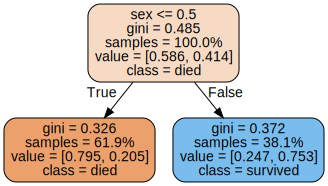

In [8]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

In [9]:
# Proportion of samples by sex
pd.value_counts(data_df.sex, normalize=True)

male      0.619048
female    0.380952
Name: sex, dtype: float64

In [10]:
# Cross tabulation of sex and survived
crosstab = pd.crosstab(
    index=data_df.sex,
    columns=data_df.survived,
    normalize='index' # Normalize by sex
)
crosstab

survived,0,1
sex,,
female,0.246528,0.753472
male,0.794872,0.205128


In [11]:
# Get p(survived) at each leaf
p_left = crosstab.loc['male', 1]
p_right = crosstab.loc['female', 1]

# Compute Gini impurity values
i_left = 2*p_left*(1-p_left)
i_right = 2*p_right*(1-p_right)
print('Gini impurity (left leaf): {:.3f}'.format(i_left))
print('Gini impurity (right leaf): {:.3f}'.format(i_right))

Gini impurity (left leaf): 0.326
Gini impurity (right leaf): 0.372


In [12]:
# Create decision tree
dt_2 = DecisionTreeClassifier(
    criterion='gini', max_depth=2, random_state=0)

# Fit decision tree
dt_2.fit(X, y)

# Get score
dt_2.score(X, y)

0.8108465608465608

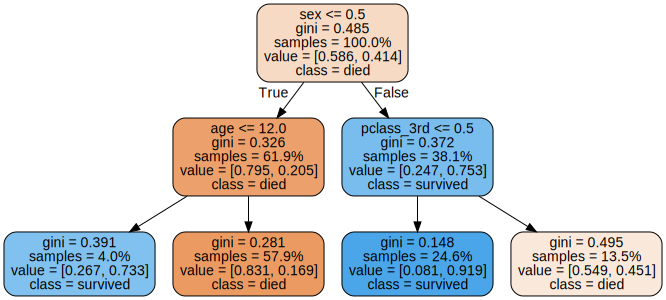

In [13]:
# Export decision tree
dot_data_2 = export_graphviz(
    dt_2, out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data_2)

In [14]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Create decision tree
dt_max_depth = DecisionTreeClassifier(
    criterion='gini', max_depth=None, random_state=0)

# Fit decision tree
dt_max_depth.fit(X_tr, y_tr)

# Get train/test scores
print('Train accuracy: {:.3f}'.format(
    dt_max_depth.score(X_tr, y_tr)))

print('Test accuracy: {:.3f}'.format(
    dt_max_depth.score(X_te, y_te)))

Train accuracy: 0.870
Test accuracy: 0.784


As we can see, the decision tree correctly classifies 87% of the samples from the train set, but only 78.4% from the test set. This is one of the main issues with decision trees. Small trees can be too simple (high bias) to model our data, and larger ones tend to overfit (high variance).